# Neural Particles 2D

## 2D Dataset
Pipeline:
* Generation of high-res data (reference) using some random cubes of water
* Extracting relevant data (particle data and grid data) like e.g. sdf, velocity, pressure, density...
* Down-sampling of particles (by a given factor) and generation of the low-res data (source)
* Extract corresponding and relevant patches on the surface from the data-set pairs (considering the low-res data)
* Use patche-pairs to train the NN

### Setup

Simple structs containing parameters for different data-set and neural network versions.

Data-set Parameters:
* **prefix**: prefix of filename
* **fps**: frames per second, the velocity of the simulation
* **frame_count**: count of generated frames
* **sub_res**: count of particles per cell (per dimension)
* **res**: resolution of high-res grid
* **var1**: factor of drop falling in basin data-sets (var0 is 1 - var1 - var2)
* **var2**: factor of two drop shooting against other
* **factor**: goal up-scale factor of particles
* **upres**: specify if the low-res grids will be up-scaled to res (=> input and output same scale)
* **seed**: seed for random data-set generation
* **min_scale**: minimum scale of boxes for data-set generation
* **max_scale**: maximum scale of boxes for data-set generation
* **min_pos**: minimum x-position of boxes
* **max_pos**: maximum x-position of boxes
* **max_h**: maximum start-height of boxes
* **max_cnt**: maximum count of boxes
* **circ_vel**: velocity used for colliding drops

Neural Network Parameters:
* **patch_size**: size of generated surface patches (of the low-res data)
* **stride**: stride used for the generation of the patches
* **surf**: surface tolerance, specifies which sdf-values are considered as surface (for patches)
* **l_fac**: multiplicative factor of low-res sdf-patches
* **h_fac**: multiplicative factor of high-res sdf-patches
* **use_tanh**: apply tanh on sdf-patches, after multiplication with factor
* **train_data_count**: count of training data-sets
* **val_split**: factor of how much of training data is used for validation
* **test_data_count**: count of test data-sets
* **t_start**: timestep start-point of data
* **t_end**: timestep end-point of data
* **features**: list of strings which specifiy which features to use:
    * 'sdf': levelset data
    * 'vel': velocity data
    * 'dens': density data
    * 'pres': pressure data
* **batch_size**: batch size used for training and validation
* **learning_rate**: learing rate used for training
* **epochs**: training epochs

In [35]:
class DatasetParam:
    def __init__(self, prefix="sph_2D", fps=30, frame_count=50, 
                 sub_res=2, res=150, var1=0, var2=0, 
                 seed=124820112, min_scale=0.05, max_scale=0.3,
                 min_pos=0.2,max_pos=0.8,max_h=0.1,max_cnt=5, circ_vel=100.):
    
        self.prefix = prefix

        self.fps = fps
        self.frame_count = frame_count
        self.sub_res = sub_res
        self.res = res
        
        self.var1 = var1
        self.var2 = var2

        self.seed = seed
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.min_pos = min_pos
        self.max_pos = max_pos
        self.max_h = max_h
        self.max_cnt = max_cnt    
        self.circ_vel = circ_vel

        
class PreParam:
    def __init__(self, patch_size=9, stride=3, surf=0.2, l_fac=1.0,h_fac=1.0,use_tanh=0, 
                 factor=10, upres=1, min_n=0, var=1, par_cnt=0):
        self.patch_size = patch_size
        self.stride = stride
        self.surf = surf
        
        self.l_fac = l_fac
        self.h_fac = h_fac
        self.use_tanh = use_tanh
        
        self.factor = factor
        self.upres = upres
        self.min_n = min_n
        self.var = var
        
        self.par_cnt = par_cnt
        
    
class NNParam:
    def __init__(self, train_data_count=5, val_split=0.2, test_data_count=1,
                 t_start = 20, t_end = 21, features=['sdf'], 
                 batch_size=32,learning_rate=1e-3,epochs=1000, residual=False, use_spc=False, explicit=False,
                 mse_fac=1., adv_fac=0.):
        self.train_data_count = train_data_count
        self.val_split = val_split
        self.test_data_count = test_data_count
        self.t_start = t_start
        self.t_end = t_end
        self.features = features
        
        self.batch_size = batch_size
        self.learning_rate=learning_rate
        self.epochs = epochs
        self.use_spc = use_spc
        self.residual = residual
        self.explicit = explicit
        self.mse_fac = mse_fac
        self.adv_fac = adv_fac    


Data Version:
* **V0**: default values, input and output patches same size
* **V1**: smaller patches, input and output patches different size, uses simple post-processing of patches
* **V2**: different seed, uses different data-set types

NN Version:
* **V0**: CNN with only sdf data
* **V1**: also velocity as input
* **V2**: 'Subpixel Convolution' instead of 'Transposed Convolution'

Combi Version:
Different combinations of data versions and NN versions.

In [36]:
data_version_param = [
    DatasetParam(),
    DatasetParam(seed=123412144,
                 var1=1./3,
                 var2=1./3),
    DatasetParam(seed=123412144,
                var1=0.5,
                frame_count=20)
]

pre_version_param = [
    PreParam(),
    PreParam(upres=0,
            stride=2,
            surf=0.5,
            factor=9,
            patch_size=5,
            h_fac=4.,
            l_fac=12.,
            use_tanh=1),
    PreParam(upres=0,
            stride=2,
            surf=0.5,
            factor=9,
            patch_size=5,
            h_fac=4.,
            l_fac=12.,
            use_tanh=1,
            min_n=3,
            var=5),
    PreParam(upres=0,
            stride=2,
            surf=0.5,
            factor=9,
            patch_size=5,
            h_fac=4.,
            l_fac=12.,
            use_tanh=1,
            min_n=3),
    PreParam(upres=0,
            stride=2,
            surf=0.5,
            factor=9,
            patch_size=5,
            h_fac=4.,
            l_fac=12.,
            use_tanh=1,
            var=5),
    PreParam(upres=0,
            stride=2,
            surf=0.5,
            factor=9,
            patch_size=5,
            h_fac=4.,
            l_fac=12.,
            use_tanh=1,
            par_cnt=10),
]

nn_version_param = [
    NNParam(),
    NNParam(train_data_count=9, 
            test_data_count=1, 
            t_start=5,
            t_end=15,
            epochs=250,
            features=['sdf','vel'],
            use_spc=True),
    NNParam(train_data_count=9, 
            test_data_count=3, 
            t_start=5,
            t_end=15,
            epochs=250,
            features=['sdf','vel'],
            use_spc=True,
            residual=True),
    NNParam(train_data_count=18, 
            test_data_count=2, 
            val_split=0.2,
            t_start=5,
            t_end=15,
            epochs=250,
            features=['sdf','vel'],
            use_spc=True,
            residual=True),
    NNParam(train_data_count=18, 
            test_data_count=2, 
            val_split=0.2,
            t_start=5,
            t_end=15,
            epochs=250,
            features=['sdf','vel'],
            use_spc=True,
            residual=True,
            mse_fac=1.0,
            adv_fac=0.01),
    NNParam(train_data_count=18, 
            test_data_count=2, 
            val_split=0.2,
            t_start=5,
            t_end=15,
            epochs=250,
            features=['ps'],
            residual=True,
            explicit=True)
]

from collections import namedtuple

Combi_Tuple = namedtuple('Combi_Tuple', ['data','pre','nn'])
version_combi_param = [
    Combi_Tuple(0,0,0), #0
    Combi_Tuple(1,0,1),
    Combi_Tuple(1,1,1),
    Combi_Tuple(1,1,2),
    Combi_Tuple(2,1,3), # <-
    Combi_Tuple(2,2,3), #5
    Combi_Tuple(2,3,3),
    Combi_Tuple(2,4,3), # <-
    Combi_Tuple(2,1,4), # <-
    Combi_Tuple(2,4,4),
    Combi_Tuple(2,5,5)  #10
]

In [37]:
import os
from subprocess import Popen, PIPE
import sys

sys.path.append("2D_SPH/scenes/tools")

import datetime

manta_loc = "2D_SPH/"

version = 10
version_combi = version_combi_param[version]
data_param = data_version_param[version_combi.data]
pre_param = pre_version_param[version_combi.pre]
nn_param = nn_version_param[version_combi.nn]

data_loc = "2D_data/"
src = "lowres"
ref = "highres"

# count of training/validation setups
data_count = nn_param.train_data_count + nn_param.test_data_count

verbose = False

def create_curr_date_folder(path):
    now = datetime.datetime.now()
    path += "%04d%02d%02d"%(now.year,now.month,now.day)
    if not os.path.exists(path):
        os.makedirs(path)
    return path + "/"

src_prefix = "%s%s/%s_v%02d-%02d" % (data_loc, src, data_param.prefix, version_combi.data, version_combi.pre)
ref_prefix = "%s%s/ref_%s_v%02d" % (data_loc, ref, data_param.prefix, version_combi.data)
test_prefix = "%stest/%s_v%02d" % (data_loc, data_param.prefix, version_combi.data)

src_patches_path = "%spatches/%s/%s_v%02d-%02d" % (data_loc, src, data_param.prefix, version_combi.data, version_combi.pre)
ref_patches_path = "%spatches/%s/ref_%s_v%02d-%02d" % (data_loc, ref, data_param.prefix, version_combi.data, version_combi.pre)


def run_manta(scene, param={},logfile=""):
    command = [manta_loc+"build/manta", manta_loc+scene]

    for k, v in param.items():
        command += [k, str(v)]
        
    if logfile != "":
        command += [">",logfile]
        command += ["; echo", "output written into %s" % logfile]
        
    print(" ".join(command) + "\n")

    proc = Popen(command, stdin=None, stdout=PIPE, stderr=PIPE)

    if verbose:
        for line in proc.stdout:
            print(line.decode('utf-8'))
    for line in proc.stderr:
        print(line.decode('utf-8'))
        
def manta_script(path):
    return manta_loc+"build/manta " + manta_loc + path
        
class ShellScript:
    def __init__(self,path,prefix=""):
        self.path = path
        self.prefix = prefix
        self.clear()
        
    def clear(self):
        self.text = "#!/bin/sh\n"
    
    def add_line(self,cmd):
        self.text += "%s %s\n" % (self.prefix, cmd)
    
    def add_param(self,param):
        l = [self.prefix]
        for k,v in param.items():
            l += [k, str(v)]
        self.text += " ".join(l) + "\n"
        
    def write(self):
        with open(self.path, 'w') as f:
            f.write(self.text)
            
        print("Shell Script generated: " + self.path)
        
        proc = Popen(["chmod","+x",self.path], stdin=None, stdout=PIPE, stderr=PIPE)

        if verbose:
            for line in proc.stdout:
                print(line.decode('utf-8'))
        for line in proc.stderr:
            print(line.decode('utf-8'))
            
    def execute(self):
        proc = Popen("./"+self.path, stdin=None)
        

In [38]:
p = "setup_dirs.sh"

setup_dir_script = ShellScript(p, "mkdir -p")
setup_dir_script.add_line(data_loc)
setup_dir_script.add_line(data_loc+src)
setup_dir_script.add_line(data_loc+ref)
setup_dir_script.add_line(data_loc+"log")
setup_dir_script.add_line("models/"+data_loc)
setup_dir_script.add_line(data_loc+"patches")
setup_dir_script.add_line(data_loc+"patches/"+src)
setup_dir_script.add_line(data_loc+"patches/"+ref)
setup_dir_script.add_line(data_loc+"result")
setup_dir_script.add_line(data_loc+"test")
setup_dir_script.add_line(data_loc+"screenshots")

setup_dir_script.write()

setup_dir_script.execute()

script_paths = {
    "ref_gen" : "gen_ref_%s_v%02d.sh" % (data_param.prefix, version_combi.data),
    "src_gen" : "gen_src_%s_v%02d-%02d.sh" % (data_param.prefix, version_combi.data, version_combi.pre),
    "patch_gen" : "gen_patches_%s_v%02d-%02d.sh" % (data_param.prefix, version_combi.data, version_combi.pre),
    "train" : "train_%s_v%02d.sh" % (data_param.prefix, version)
}

p = "complete_%s_v%02d.sh" % (data_param.prefix, version)
complete_script = ShellScript(p)
complete_script.add_line("./"+script_paths['ref_gen'])
complete_script.add_line("./"+script_paths['src_gen'])
complete_script.add_line("./"+script_paths['patch_gen'])
complete_script.add_line("./"+script_paths['train'])
complete_script.write()

print("Execute Script for data generation and training: " + p)

p = "clean_%s_v%02d.sh" % (data_param.prefix, version)
clean_script = ShellScript(p, "rm")
clean_script.add_line(ref_prefix+"*")
#clean_script.add_line(test_prefix+"*")
clean_script.add_line(src_prefix+"*")
clean_script.add_line(src_patches_path+"*")
clean_script.add_line(ref_patches_path+"*")
clean_script.write()

print("Execute Script to remove generated data: " + p)

Shell Script generated: setup_dirs.sh
Shell Script generated: complete_sph_2D_v10.sh
Execute Script for data generation and training: complete_sph_2D_v10.sh
Shell Script generated: clean_sph_2D_v10.sh
Execute Script to remove generated data: clean_sph_2D_v10.sh


Compute 2D down-scale factor:
$$lowres=\frac{res}{\sqrt(factor)}$$

In [39]:
import math

low_res = data_param.res
high_patch_size = pre_param.patch_size
factor_2D = 1.
if not pre_param.upres:
    factor_2D = math.sqrt(pre_param.factor)
    low_res = int(low_res/factor_2D)
    high_patch_size = int(high_patch_size*factor_2D)
    
print("2D factor: %f" % factor_2D)
print("low resolution: %d" % low_res)
print("big patch size. %d" % high_patch_size)

2D factor: 3.000000
low resolution: 50
big patch size. 15


### Generate Data

In [96]:
import random

script = ShellScript(script_paths["ref_gen"], manta_script("scenes/2D_sph.py"))

param = {}

#disable gui
param['gui'] = 0

param['sres'] = data_param.sub_res

# write only every 30th frame -> 30 frames are one timestep
param['fps'] = data_param.fps

# simulation time (how many frames)
param['t_end'] = float(data_param.frame_count) / data_param.fps

# run random training setups
random.seed(data_param.seed)

def call_dataset_gen(var0,var1,var2,off):
    def run_gen(cubes,cnt):
        param['c_cnt'] = len(cubes)
        
        param['res'] = data_param.res
        param['out'] = (ref_prefix + "_d%03d")%cnt + "_%03d"
        script.add_param(dict(param, **cubes))
        
        param['res'] = low_res
        param['out'] = (test_prefix + "_d%03d")%cnt + "_%03d"
        script.add_param(dict(param, **cubes))        
        
    param['circ'] = 0
    for i in range(var0):
        # generate different cubes with dataformat "pos_x,pos_y,scale_x,scale_y"
        cubes = {}
        for c in range(random.randint(1,data_param.max_cnt)):    
            scx = random.uniform(data_param.min_scale, data_param.max_scale)
            scy = random.uniform(data_param.min_scale, data_param.max_scale)
            px = random.uniform(data_param.min_pos+scx/2, data_param.max_pos-scx/2)
            py = random.uniform(0, data_param.max_h) + scy/2
            cubes['c%d'%c] = "%f,%f,%f,%f"%(px,py,scx,scy)
        run_gen(cubes,off)
        off+=1
        

    for i in range(var1):
        cubes = {}
        scy = data_param.max_h
        cubes['c0'] = "%f,%f,%f,%f"%(0, scy/2, 1, scy)
        for c in range(1,random.randint(2,data_param.max_cnt)):    
            scx = random.uniform(data_param.min_scale, data_param.max_scale)*0.5
            scy = random.uniform(data_param.min_scale, data_param.max_scale)*0.5
            px = random.uniform(data_param.min_pos+scx/2, data_param.max_pos-scx/2)
            py = random.uniform(data_param.min_pos+scy/2, data_param.max_pos*0.5-scy/2)
            cubes['c%d'%c] = "%f,%f,%f,%f"%(px,py,scx,scy)
        run_gen(cubes, off)
        off+=1

    param['circ'] = data_param.circ_vel
    for i in range(var2):
        cubes = {}
        for c in range(random.randint(2,data_param.max_cnt)):    
            scx = random.uniform(data_param.min_scale, data_param.max_scale)*0.5
            scy = random.uniform(data_param.min_scale, data_param.max_scale)*0.5
            px = random.uniform(data_param.min_pos+scx/2, data_param.max_pos-scx/2)
            py = random.uniform(data_param.min_pos+scy/2, data_param.max_pos-scy/2)
            cubes['c%d'%c] = "%f,%f,%f,%f"%(px,py,scx,scy)
        run_gen(cubes, off)
        off+=1
    
var1 = int(nn_param.train_data_count * data_param.var1)
var2 = int(nn_param.train_data_count * data_param.var2)
var0 = nn_param.train_data_count - var1 - var2
 
call_dataset_gen(var0,var1,var2,0)

var1 = int(nn_param.test_data_count * data_param.var1)
var2 = int(nn_param.test_data_count * data_param.var2)
var0 = nn_param.test_data_count - var1 - var2

call_dataset_gen(var0,var1,var2,nn_param.train_data_count)

script.write()

print("Execute Script for reference data generation: " + script_paths["ref_gen"])

#script.execute()

Shell Script generated: gen_ref_sph_2D_v02.sh
Execute Script for reference data generation: gen_ref_sph_2D_v02.sh


### Generate Low-res Data

In [53]:
import random

script = ShellScript(script_paths["src_gen"], manta_script("scenes/down_scale.py"))

param = {}

param['res'] = data_param.res
param['sres'] = data_param.sub_res
param['upres'] = pre_param.upres
 
param['factor'] = pre_param.factor
param['gui'] = 0
param['t'] = data_param.frame_count
param['min_n'] = pre_param.min_n

random.seed(data_param.seed)

for i in range(data_count):
    for j in range(pre_param.var):
        param['seed'] = random.randint(0,45820438204)
        param['in'] = (ref_prefix + "_d%03d")%(i) + "_%03d"
        param['out'] = (src_prefix + "_d%03d_var%02d")%(i,j) + "_%03d"
        script.add_param(param)     
        #run_manta("scenes/down_scale.py", param)
        
script.write()

print("Execute Script for source data generation: " + script_paths["src_gen"])

Shell Script generated: gen_src_sph_2D_v02-05.sh
Execute Script for source data generation: gen_src_sph_2D_v02-05.sh


### Extract Surface-Patches

In [52]:
script = ShellScript(script_paths["patch_gen"], manta_script("scenes/extract_patches.py"))

param = {}

param["t"] = data_param.frame_count

# patch size
param["psize"] = pre_param.patch_size
param["stride"] = pre_param.stride

param["hpsize"] = high_patch_size

param["l_fac"] = pre_param.l_fac
param["h_fac"] = pre_param.h_fac
param["tanh"] = pre_param.use_tanh

param['par_cnt'] = pre_param.par_cnt

# tolerance of surface
param["surface"] = pre_param.surf

for i in range(data_count):
    for j in range(pre_param.var):
        param["h_in"] = ref_prefix + "_d%03d"%(i) + "_%03d"
        param["l_in"] = src_prefix + "_d%03d_var%02d"%(i,j) + "_%03d"
        param["h_out"] = ref_patches_path + "_d%03d_var%02d"%(i,j) + "_%03d"
        param["l_out"] = src_patches_path + "_d%03d_var%02d"%(i,j) + "_%03d"
        script.add_param(param)
        #run_manta("scenes/extract_patches.py", param)
        
script.write()
print("Execute Script for patch generation: " + script_paths["patch_gen"])

Shell Script generated: gen_patches_sph_2D_v02-05.sh
Execute Script for patch generation: gen_patches_sph_2D_v02-05.sh


### Show Data

**Show low-res data-sets:**

In [97]:
param = {}
dataset = 19
var = 0

# show low res
param['in'] = src_prefix + "_d%03d_var%02d"%(dataset,var) + "_%03d_ps.uni"
param['sdf'] = src_prefix + "_d%03d_var%02d"%(dataset,var) + "_%03d_sdf.uni"
param['t'] = data_param.frame_count
param['res'] = low_res

#param['scr'] = #create_curr_date_folder(data_loc+'screenshots/') + "sph_%03d_sdf.png"

run_manta("scenes/show_particles.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_particles.py in 2D_data/lowres/sph_2D_v02-01_d019_var00_%03d_ps.uni res 50 t 20 sdf 2D_data/lowres/sph_2D_v02-01_d019_var00_%03d_sdf.uni

QThread: Destroyed while thread is still running



**Show real low-res data-sets:**

In [98]:
param = {}
dataset = 19

# show high res
param['in'] = test_prefix + "_d%03d"%dataset + "_%03d_ps.uni"
param['sdf'] = test_prefix + "_d%03d"%dataset + "_%03d_sdf.uni"
param['t'] = data_param.frame_count
param['res'] = low_res

#param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + "sph_real_%03d_sdf_ref.png"

run_manta("scenes/show_particles.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_particles.py in 2D_data/test/sph_2D_v02_d019_%03d_ps.uni res 50 t 20 sdf 2D_data/test/sph_2D_v02_d019_%03d_sdf.uni

QThread: Destroyed while thread is still running



**Show high-res data-sets:**

In [79]:
param = {}
dataset = 19

# show high res
param['in'] = ref_prefix + "_d%03d"%dataset + "_%03d_ps.uni"
param['sdf'] = ref_prefix + "_d%03d"%dataset + "_%03d_sdf.uni"
param['t'] = data_param.frame_count
param['res'] = data_param.res

#param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + "sph_%03d_sdf_ref.png"

run_manta("scenes/show_particles.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_particles.py res 150 sdf 2D_data/highres/ref_sph_2D_v02_d019_%03d_sdf.uni in 2D_data/highres/ref_sph_2D_v02_d019_%03d_ps.uni t 20



**Show patches:**

In [54]:
param = {}
dataset = 0
timestep = 10
var = 0

# show patches
param['src'] = src_patches_path + "_d%03d_var%02d"%(dataset,var) + "_%03d_sdf"%timestep
param['vel'] = src_patches_path + "_d%03d_var%02d"%(dataset,var) + "_%03d_vel"%timestep
param['ps'] =  src_patches_path + "_d%03d_var%02d"%(dataset,var) + "_%03d_ps" %timestep
param['ref'] = ref_patches_path + "_d%03d_var%02d"%(dataset,var) + "_%03d_sdf"%timestep
param['psize'] = pre_param.patch_size
param['hpsize'] = high_patch_size
param['t'] = 1#data_param.frame_count

#param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + "sph_patch_%03d_sdf_ref.png"

run_manta("scenes/show_patches.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_patches.py ref 2D_data/patches/highres/ref_sph_2D_v02-05_d000_var00_010_sdf psize 5 ps 2D_data/patches/lowres/sph_2D_v02-05_d000_var00_010_ps hpsize 15 src 2D_data/patches/lowres/sph_2D_v02-05_d000_var00_010_sdf vel 2D_data/patches/lowres/sph_2D_v02-05_d000_var00_010_vel t 1

Traceback (most recent call last):

  File "2D_SPH/scenes/show_patches.py", line 141, in <module>

    s.step()

RuntimeError: User interrupt



## Train Neural Network

### Setup Neural Network

In [40]:
import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Input, ZeroPadding2D, Dense
from keras.layers import Reshape, RepeatVector, Permute, concatenate, add, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from subpixel import *
from keras import regularizers
import numpy as np

feature_cnt = 4
print("feature_count: %d" % feature_cnt)

model = None

model_path = 'models/2D/%s_v%02d' % (data_param.prefix, version)
print(model_path)
fig_path = '%s_loss' % model_path

inputs = Input((pre_param.patch_size, pre_param.patch_size, 1), name="main_input")
auxiliary_input = Input(shape=(pre_param.patch_size, pre_param.patch_size, feature_cnt-1), name="auxiliary_input")

feature_count: 4
models/2D/sph_2D_v10


#### ESPCNN

In [41]:
if not nn_param.residual and not nn_param.explicit:
    x = concatenate([inputs, auxiliary_input], name="concatenate")
    
    x = Conv2D(filters=3, kernel_size=3, 
               strides=1, input_shape=input_shape, 
               activation='tanh', padding='same', name="conv2D_0")(x)

    x = Conv2D(filters=9, kernel_size=3,
               strides=1, activation='tanh', padding='same', name="conv2D_1")(x)

    #model.add( keras.layers.BatchNormalization() )  

    if nn_param.use_spc:
        print("Use Subpixel Convolution")
        predictions = Subpixel(filters=1, kernel_size=3, r=3,activation='tanh', padding='same', name="subpixel_conv")(x)
    else:
        x = Conv2DTranspose(filters=3, kernel_size=3, 
                            strides=int(factor_2D), activation='tanh', padding='same', name="deconv2D_0")(x)
        predictions = Conv2DTranspose(filters=1, kernel_size=3, 
                            strides=1, activation='tanh', padding='same', name="deconv2D_1")(x)
        
    model = Model(inputs=[inputs,auxiliary_input], outputs=predictions)
    model.summary()
    model.compile( loss='mse', optimizer=keras.optimizers.adam(lr=nn_param.learning_rate))
    
    model.save(model_path + '.h5')

#### Residual ESPCNN

In [42]:
if nn_param.residual and not nn_param.explicit:   
    base = Reshape((pre_param.patch_size*pre_param.patch_size,), name="reshape_flat")(inputs)
    base = RepeatVector(9, name="repeate")(base)
    base = Permute((2, 1), name="permute")(base)
    base = Reshape((pre_param.patch_size, pre_param.patch_size,9), name="reshape_back")(base)
    
    x = concatenate([inputs, auxiliary_input], name="concatenate")
    x = Reshape((pre_param.patch_size*pre_param.patch_size*feature_cnt,), name="reshape_flat_res")(x)
    x = RepeatVector(9, name="repeate_res")(x)
    x = Permute((2, 1), name="permute_res")(x)
    x = Reshape((pre_param.patch_size, pre_param.patch_size,9*feature_cnt), name="reshape_back_res")(x)
    
    #x = concatenate([base, auxiliary_input], name="concatenate")
    
    x = Conv2D(filters=16*feature_cnt, kernel_size=3, 
               strides=1, activation='tanh', padding='same', name="conv2D_0")(x)
    x = BatchNormalization(name="normalize_0")(x)
    x = Conv2D(filters=32*feature_cnt, kernel_size=3,
               strides=1, activation='tanh', padding='same', name="conv2D_1")(x)    
    x = BatchNormalization(name="normalize_1")(x)
    x = Conv2DTranspose(filters=16*feature_cnt, kernel_size=3, 
                        strides=1, activation='tanh', padding='same', name="deconv2D_0")(x)
    x = BatchNormalization(name="normalize_2")(x)
    x = Conv2DTranspose(filters=9, kernel_size=3, 
                        strides=1, activation='tanh', padding='same', name="deconv2D_1")(x)
    x = BatchNormalization(name="normalize_3")(x)
    
    x = add([base,x], name="add")
    x = Activation('tanh', name="activation")(x)
    predictions = Subpixel(filters=1, kernel_size=3, r=3,activation='tanh', padding='same', name="subpixel_conv")(x)
    
    generator = Model(inputs=[inputs,auxiliary_input], outputs=predictions, name="generator")
    generator.compile( loss='mse', optimizer=keras.optimizers.adam(lr=nn_param.learning_rate))
    
    generator.save(model_path + '.h5')
    
    generator.summary()

#### Discriminator

In [43]:
if nn_param.adv_fac > 0.:
    discriminator = Sequential(name="discriminator")

    img_shape = (high_patch_size, high_patch_size, 1)

    discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(BatchNormalization(momentum=0.8))
    #model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    #model.add(LeakyReLU(alpha=0.2))

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    #img = Input(shape=img_shape, name="disc_input")
    #validity = model(img)

    #discriminator = Model(img, validity)

    discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.adam(lr=nn_param.learning_rate), metrics=['accuracy'])

    discriminator.save(model_path + '_dis.h5')

    discriminator.summary()

**Particle Network:**

In [44]:
if nn_param.residual and nn_param.explicit:  
    par_in = Input((pre_param.par_cnt,3), name="main")
    
    base = Flatten()(par_in)
    base = Dense(100, activation='tanh')(base)
    
    x = Conv2D(filters=16, kernel_size=3, 
               strides=1, activation='tanh', padding='same', name="conv2D_0")(auxiliary_input)
    x = BatchNormalization(name="normalize_0")(x)
    x = Conv2D(filters=32, kernel_size=3,
               strides=1, activation='tanh', padding='same', name="conv2D_1")(x)    
    x = BatchNormalization(name="normalize_1")(x)
    x = Conv2DTranspose(filters=16, kernel_size=3, 
                        strides=1, activation='tanh', padding='same', name="deconv2D_0")(x)
    x = BatchNormalization(name="normalize_2")(x)
    x = Conv2DTranspose(filters=4, kernel_size=3, 
                        strides=1, activation='tanh', padding='same', name="deconv2D_1")(x)
    x = BatchNormalization(name="normalize_3")(x)
    
    x = Reshape((pre_param.patch_size*pre_param.patch_size*4,))
    
    #base = concatenate([base, x], name="concatenate")
    
    base = Dense(100, activation='tanh')(base)
    base = Dense(pre_param.par_cnt*3, activation='tanh')(base)
    out = Reshape((pre_param.par_cnt,3))(base)
    
    model = Model(inputs=par_in, outputs=out)
    model.compile( loss='mse', optimizer=keras.optimizers.adam(lr=nn_param.learning_rate))
    
    model.save(model_path + '.h5')
    
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main (InputLayer)            (None, 10, 3)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 30)                3030      
_________________________________________________________________
reshape_11 (Reshape)         (None, 10, 3)             0         
Total params: 16,230
Trainable params: 16,230
Non-trainable params: 0
_________________________________________________________________


**Train:**

In [45]:
script = ShellScript(script_paths["train"], "python3 " + manta_loc + ("scenes/tools/train_gan.py" if nn_param.adv_fac > 0. else "scenes/tools/train_sequential.py"))

param = {}

param['src'] = "%spatches/%s/%s_v%02d-%02d" % (data_loc, src, data_param.prefix, version_combi.data, version_combi.pre) + "_d%03d_var%02d" + "_%03d"
param['ref'] = "%spatches/%s/ref_%s_v%02d-%02d" % (data_loc, ref, data_param.prefix, version_combi.data, version_combi.pre) + "_d%03d_var%02d" + "_%03d"
param['data_start'] = 0
param['data_end'] = nn_param.train_data_count
param['time_start'] = nn_param.t_start
param['time_end'] = nn_param.t_end
param['var'] = pre_param.var
param['features'] = ",".join(nn_param.features)

param['val_split'] = nn_param.val_split
param['epochs'] = nn_param.epochs
param['batch'] = nn_param.batch_size
param['log_intervall'] = 10
param['checkpoint_intervall'] = 10
param['model'] = model_path
param['fig'] = fig_path

if nn_param.adv_fac > 0.:
    param['lr'] = nn_param.learning_rate
    param['mse'] = nn_param.mse_fac
    param['adv'] = nn_param.adv_fac

script.add_param(param)
        
script.write()
print("Execute Script for training: " + script_paths["train"])

Shell Script generated: train_sph_2D_v10.sh
Execute Script for training: train_sph_2D_v10.sh


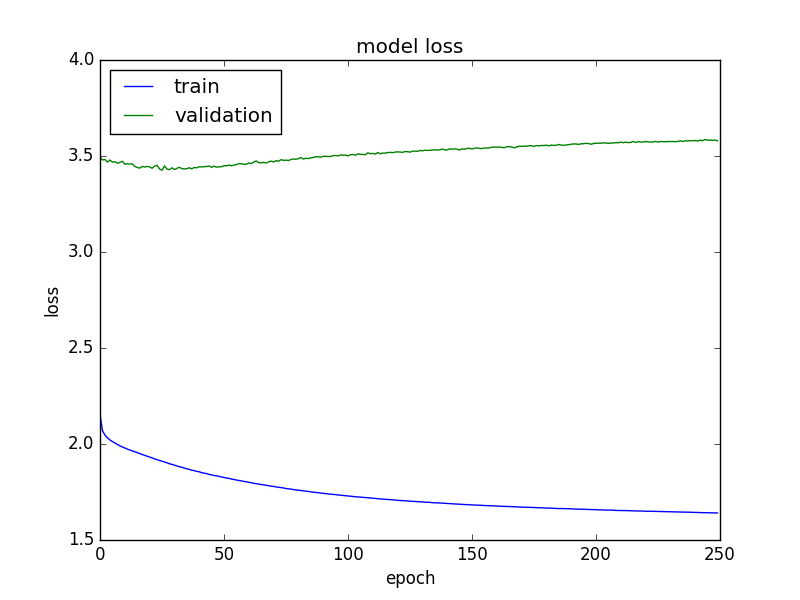

In [18]:
from IPython.display import Image
Image(filename=fig_path+".png") 

### Run Neural Network

In [21]:
import keras
from keras.models import load_model
from subpixel import *

model = load_model(model_path+"_trained.h5", custom_objects={'Subpixel': Subpixel})

from dataset import Dataset
src_patches_path = "%spatches/%s/%s_v%02d-%02d" % (data_loc, src, data_param.prefix, version_combi.data, version_combi.pre) + "_d%03d_var%02d" + "_%03d"
print(src_patches_path)
ref_patches_path = "%spatches/%s/ref_%s_v%02d-%02d" % (data_loc, ref, data_param.prefix, version_combi.data, version_combi.pre) + "_d%03d_var%02d" + "_%03d"
print(ref_patches_path)

test_data = Dataset(src_patches_path, 
                    nn_param.train_data_count, nn_param.train_data_count + nn_param.test_data_count, nn_param.t_start, nn_param.t_end, 
                    nn_param.features, pre_param.var, ref_patches_path, [nn_param.features[0]])

print(test_data.data[nn_param.features[0]].shape)
print(test_data.ref_data[nn_param.features[0]].shape)

2D_data/patches/lowres/sph_2D_v02-05_d%03d_var%02d_%03d
2D_data/patches/highres/ref_sph_2D_v02-05_d%03d_var%02d_%03d
(631, 10, 3)
(631, 10, 3)


**Validate:**

In [22]:
x,y = test_data.get_data_splitted()
loss_and_metrics = model.evaluate(x=x, y=y, batch_size=nn_param.batch_size)
print(loss_and_metrics)

 32/631 [>.............................] - ETA: 1s1.54577337477


#### Show Results

In [24]:
from uniio import *

timestep = (nn_param.t_start + nn_param.t_end) // 2

test_filename = "%sresult/%s_v%02d" % (data_loc, data_param.prefix, version) + "_%03d_sdf" % timestep
ref_filename = "%sresult/ref_%s_v%02d" % (data_loc, data_param.prefix, version) + "_%03d_sdf" % timestep
result_filename = "%sresult/result_%s_v%02d" % (data_loc, data_param.prefix, version) + "_%03d_sdf" % timestep

#remove_data(test_filename)
#remove_data(ref_filename)
#remove_data(result_filename)

x,y = test_data.get_data_splitted()
result = model.predict(x=x, batch_size=nn_param.batch_size)

for patch in test_data.data[nn_param.features[0]]:
    writeNumpyBuf(test_filename, patch[:,:,0])
    
for patch in test_data.ref_data[nn_param.features[0]]:
    writeNumpyBuf(ref_filename, patch)
    
for patch in result:
    writeNumpyBuf(result_filename, patch)
    
finalizeNumpyBufs()

IndexError: too many indices for array

In [44]:
param = {}

# show patches
param['src'] = test_filename
param['ref'] = result_filename
param['ref2'] = ref_filename
param['psize'] = pre_param.patch_size
param['hpsize'] = high_patch_size
param['t'] = 1

param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + "sph_patch_%03d_sdf_res.png"

run_manta("scenes/show_patches.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_patches.py hpsize 15 src 2D_data/result/sph_2D_v08_010_sdf ref 2D_data/result/result_sph_2D_v08_010_sdf scr 2D_data/screenshots/20171127/sph_patch_%03d_sdf_res.png ref2 2D_data/result/ref_sph_2D_v08_010_sdf psize 5 t 1

Traceback (most recent call last):

  File "2D_SPH/scenes/show_patches.py", line 57, in <module>

    if pause: gui.pause()

RuntimeError: User interrupt



### Complete Application

In [37]:
import scipy.ndimage.filters as fi
import math
import numpy as np

def filter2D(kernlen, s, fac):
    dirac = np.zeros((kernlen, kernlen))
    dirac[kernlen//2, kernlen//2] = 1
    return np.clip(fi.gaussian_filter(dirac, s) * fac, a_min=None, a_max=1.0)

result = np.ndarray(shape=(data_param.res,data_param.res,1), dtype=float)

ps = pre_param.patch_size//2
hps = high_patch_size//2

border = int(math.ceil(hps-(ps*factor_2D)))

result=np.pad(result,((border,border),(border,border),(0,0)),mode="edge")

elem_min = np.vectorize(lambda x,y: min(x,y))
circular_filter = filter2D(high_patch_size, high_patch_size*0.2, 500)

def super_res(input_path, output_path, t_start, t_end, model):
    for t in range(t_start, t_end):
        result.fill(1)
        hdr, source = readUni(input_path%t+"_sdf.uni")
        for f in nn_param.features:
            if f != "sdf":
                _, tmp = readUni(input_path%t+"_"+f+".uni")
                source = np.append(source, tmp, axis=3)

        for x in range (ps, low_res-ps, 1):
            for y in range(ps, low_res-ps, 1):
                if(abs(source[0,x,y,0]) < pre_param.surf):
                    x0=x-ps
                    x1=x+ps+1
                    y0=y-ps
                    y1=y+ps+1

                    data = np.array([source[0,x0:x1,y0:y1]]) * pre_param.l_fac
                    if pre_param.use_tanh != 0:
                        data[0,:,:,0] = np.tanh(data[0,:,:,0])

                    predict = model.predict(x=np.split(data,[1],axis=3), batch_size=1)
                    if pre_param.use_tanh != 0:
                        predict = np.arctanh(np.clip(predict,-.999999,.999999))

                    predict = predict * circular_filter/pre_param.h_fac

                    x0=int(factor_2D*x)-hps+border
                    x1=int(factor_2D*x)+hps+border+1
                    y0=int(factor_2D*y)-hps+border
                    y1=int(factor_2D*y)+hps+border+1

                    result[x0:x1,y0:y1,0] = elem_min(result[x0:x1,y0:y1,0], predict[0,:,:,0])

        hdr['dimX'] = data_param.res
        hdr['dimY'] = data_param.res

        writeUni(output_path%t, hdr, result[border:data_param.res+border,border:data_param.res+border,0])

**Calculate Super Resolution**

In [38]:
use_real_data = False

dataset = 18#nn_param.train_data_count
var = 0

input_path = (test_prefix if use_real_data else src_prefix) + "_d%03d" % dataset + ("_var%02d"%var if not use_real_data else "") + "_%03d"
ref_input_path = ref_prefix + "_d%03d" % dataset + "_%03d_sdf.uni"
print(input_path)
print(ref_input_path)
output_path = "%sresult/%s_v%02d_d%03d" % (data_loc, data_param.prefix, version, dataset) + "_%03d_result.uni"
print(output_path)

super_res(input_path, output_path, nn_param.t_start, nn_param.t_end, model)

scr_path =  ("real_" if use_real_data else "") + "%s_v%02d_d%03d" % (data_param.prefix, version, dataset) + "_%03d"
if nn_param.t_end - nn_param.t_start <= 1: 
    scr_path = scr_path % nn_param.t_start
    input_path = input_path % nn_param.t_start
    output_path = output_path % nn_param.t_start
    ref_input_path = ref_input_path % nn_param.t_start

2D_data/lowres/sph_2D_v02-01_d018_var00_%03d
2D_data/highres/ref_sph_2D_v02_d018_%03d_sdf.uni
2D_data/result/sph_2D_v08_d018_%03d_result.uni


**Naiive Up-res**

In [31]:
param = {}

# show input
param['sdf'] = input_path+"_sdf.uni"
param['t_start'] = nn_param.t_start
param['t_end'] = nn_param.t_end
param['res'] = low_res
param['upres'] = data_param.res

param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + 'simple_' + scr_path + ".png"

run_manta("scenes/up_scale.py", param)

2D_SPH/build/manta 2D_SPH/scenes/up_scale.py t_end 15 upres 150 scr 2D_data/screenshots/20171121/simple_sph_2D_v05_d018_%03d.png res 50 sdf 2D_data/lowres/sph_2D_v02-02_d018_var00_%03d_sdf.uni t_start 5



**Show source frame:**

In [20]:
param = {}

# show input
param['sdf'] = input_path+"_sdf.uni"
param['t_start'] = nn_param.t_start
param['t_end'] = nn_param.t_end
param['res'] = low_res
param['sres'] = data_param.sub_res

param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + 'src_' + scr_path + ".png"

run_manta("scenes/show_particles.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_particles.py t_start 5 t_end 15 scr 2D_data/screenshots/20171127/src_sph_2D_v08_d018_%03d.png res 50 sres 2 sdf 2D_data/lowres/sph_2D_v02-01_d018_var00_%03d_sdf.uni

QThread: Destroyed while thread is still running



**Show result frame:**

In [31]:
param = {}

# show result
param['sdf'] = output_path
param['t_start'] = nn_param.t_start
param['t_end'] = nn_param.t_end
param['res'] = data_param.res
param['sres'] = data_param.sub_res

param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + 'res_' + scr_path + ".png"

run_manta("scenes/show_particles.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_particles.py t_start 5 t_end 15 scr 2D_data/screenshots/20171127/res_sph_2D_v08_d018_%03d.png res 150 sres 2 sdf 2D_data/result/sph_2D_v08_d018_%03d_result.uni

Traceback (most recent call last):

  File "2D_SPH/scenes/show_particles.py", line 63, in <module>

    sampleLevelsetWithParticles(phi=sdf, flags=gFlags, parts=pp, discretization=sres, randomness=0)

RuntimeError: User interrupt



**Show reference:**

In [34]:
param = {}

# show result
param['sdf'] = ref_input_path
param['t_start'] = nn_param.t_start
param['t_end'] = nn_param.t_end
param['res'] = data_param.res
param['sres'] = data_param.sub_res

param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + 'ref_' + scr_path + ".png"

run_manta("scenes/show_particles.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_particles.py sres 2 t_end 15 scr 2D_data/screenshots/20171121/ref_sph_2D_v05_d018_%03d.png res 150 sdf 2D_data/highres/ref_sph_2D_v02_d018_%03d_sdf.uni t_start 5



**Show Evolution**

In [39]:
evolv_output = "%sresult/%s_v%02d_d%03d" % (data_loc, data_param.prefix, version, dataset) + "_%03d_result"
for e in range(1,nn_param.epochs//10+1):
    print(evolv_output + "_e%04d.uni"%e)
    super_res(input_path, evolv_output + "_e%04d.uni"%e, nn_param.t_end-1, nn_param.t_end, load_model(model_path+"_%04d.h5"%e, custom_objects={'Subpixel': Subpixel}))

2D_data/result/sph_2D_v08_d018_%03d_result_e0001.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0002.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0003.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0004.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0005.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0006.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0007.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0008.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0009.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0010.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0011.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0012.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0013.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0014.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0015.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0016.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0017.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e0018.uni
2D_data/result/sph_2D_v08_d018_%03d_result_e00

In [41]:
param = {}
dataset = 0

# show result
param['sdf'] = evolv_output%(nn_param.t_end-1)+"_e%04d.uni"
param['t_start'] = 1
param['t_end'] = nn_param.epochs//10+1
param['res'] = data_param.res
param['sres'] = data_param.sub_res

param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + 'evolv_' + scr_path + ".png"

run_manta("scenes/show_particles.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_particles.py t_start 1 t_end 26 scr 2D_data/screenshots/20171127/evolv_sph_2D_v08_d018_%03d.png res 150 sres 2 sdf 2D_data/result/sph_2D_v08_d018_014_result_e%04d.uni



#### Show Particle NN Result

In [17]:
import scipy.ndimage.filters as fi
import math

ps = pre_param.patch_size//2
hps = high_patch_size//2

dataset = 18#nn_param.train_data_count

input_path = src_prefix + "_d%03d" % dataset + "_%03d"
ref_input_path = ref_prefix + "_d%03d" % dataset + "_%03d_sdf.uni"
output_path = "%sresult/%s_v%02d_d%03d" % (data_loc, data_param.prefix, version, dataset) + "_%03d_ps_result.uni"

def particle_range(arr, start, end):
    for i in range(len(start)):
        arr = arr[np.where((arr[:,i]>=start[i])&(arr[:,i]<=end[i]))]
    return arr

for t in range(nn_param.t_start, nn_param.t_end):
    result = None
    hdr, particle_src = readParticles(input_path%t+"_ps.uni")
    sdf_source = readUni(input_path%t+"_sdf.uni")[1]

    for x in range (ps, low_res-ps, 1):
        for y in range(ps, low_res-ps, 1):
            if(abs(sdf_source[0,x,y,0]) < 0.5):
                x0=x-ps
                x1=x+ps+1
                y0=y-ps
                y1=y+ps+1
                
                par = numpy.subtract(particle_range(l_particle_data, [x0, y0], [x1, y1]), [(x0+x1)/2, (y0+y1)/2, 0.])
                if par.shape[0] < nn_param.particle_cnt:
                    continue

                idx = np.argsort(np.linalg.norm(par,axis=1))
                
                predict = model.predict(x=np.array([par[idx[:particle_cnt]]]), batch_size=1)
                
                if result is None:
                    result = np.add(predict,[(x0+x1)/2, (y0+y1)/2, 0.])
                else:
                    result = np.append(result, np.add(predict,[(x0+x1)/2, (y0+y1)/2, 0.]), axis=0)

    hdr['dim'] = len(result)

    #print(result[border:data_param.res+border,border:data_param.res+border,0].shape)
    writeParticles(output_path%t, hdr, result)

Reading 2D_data/lowres/sph_2D_v01-01_d004_005_ps.uni ... 
(BasicParticleSystem) 
Done.
Reading 2D_data/lowres/sph_2D_v01-01_d004_006_ps.uni ... 
(BasicParticleSystem) 
Done.
Reading 2D_data/lowres/sph_2D_v01-01_d004_007_ps.uni ... 
(BasicParticleSystem) 
Done.
Reading 2D_data/lowres/sph_2D_v01-01_d004_008_ps.uni ... 
(BasicParticleSystem) 
Done.
Reading 2D_data/lowres/sph_2D_v01-01_d004_009_ps.uni ... 
(BasicParticleSystem) 
Done.
Reading 2D_data/lowres/sph_2D_v01-01_d004_010_ps.uni ... 
(BasicParticleSystem) 
Done.
Reading 2D_data/lowres/sph_2D_v01-01_d004_011_ps.uni ... 
(BasicParticleSystem) 
Done.
Reading 2D_data/lowres/sph_2D_v01-01_d004_012_ps.uni ... 
(BasicParticleSystem) 
Done.
Reading 2D_data/lowres/sph_2D_v01-01_d004_013_ps.uni ... 
(BasicParticleSystem) 
Done.
Reading 2D_data/lowres/sph_2D_v01-01_d004_014_ps.uni ... 
(BasicParticleSystem) 
Done.


In [19]:
param = {}
dataset = 4

# show high res
param['in'] = output_path
param['sdf'] = ref_prefix + "_d%03d"%dataset + "_%03d_sdf.uni"
param['t_start'] = nn_param.t_start
param['t_end'] = nn_param.t_end
param['res'] = data_param.res

#param['scr'] = create_curr_date_folder(data_loc+'screenshots/') + "sph_%03d_sdf_ref.png"

run_manta("scenes/show_particles.py", param)

2D_SPH/build/manta 2D_SPH/scenes/show_particles.py in 2D_data/result/sph_2D_v03_d004_%03d_ps_result.uni res 150 sdf 2D_data/highres/ref_sph_2D_v01_d004_%03d_sdf.uni t_end 15 t_start 5



In [130]:
import keras
import numpy as np

i = keras.layers.Input((3,3,1))
ai = keras.layers.Input((3,3,1))
x = concatenate([i, ai])
x = Reshape((3*3*2,))(x)
x = RepeatVector(9)(x)
x = Permute((2, 1))(x)
x = Reshape((3, 3, 18))(x)
    
#x = concatenate([x, ai])

#x = i

#x = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', name="conv")(x)

model = keras.layers.Model(inputs=[i,ai],outputs=x)
model.compile(loss='mse', optimizer=keras.optimizers.adam(lr=0.1))

data = np.array([[[[0.],[1.],[2.]],[[3.],[4.],[5.]],[[6.],[7.],[8.]]]])
aux = np.array([[[[10.],[11.],[12.]],[[13.],[14.],[15.]],[[16.],[17.],[18.]]]])
print(data)
print("+")
print(aux)
print("=>")
print(model.predict([data,aux]))
#print(model.get_layer("conv").get_weights()[0].shape)
#print(model.get_layer("conv").get_weights())

[[[[ 0.]
   [ 1.]
   [ 2.]]

  [[ 3.]
   [ 4.]
   [ 5.]]

  [[ 6.]
   [ 7.]
   [ 8.]]]]
+
[[[[ 10.]
   [ 11.]
   [ 12.]]

  [[ 13.]
   [ 14.]
   [ 15.]]

  [[ 16.]
   [ 17.]
   [ 18.]]]]
=>
[[[[  0.   0.   0.   0.   0.   0.   0.   0.   0.  10.  10.  10.  10.  10.
     10.  10.  10.  10.]
   [  1.   1.   1.   1.   1.   1.   1.   1.   1.  11.  11.  11.  11.  11.
     11.  11.  11.  11.]
   [  2.   2.   2.   2.   2.   2.   2.   2.   2.  12.  12.  12.  12.  12.
     12.  12.  12.  12.]]

  [[  3.   3.   3.   3.   3.   3.   3.   3.   3.  13.  13.  13.  13.  13.
     13.  13.  13.  13.]
   [  4.   4.   4.   4.   4.   4.   4.   4.   4.  14.  14.  14.  14.  14.
     14.  14.  14.  14.]
   [  5.   5.   5.   5.   5.   5.   5.   5.   5.  15.  15.  15.  15.  15.
     15.  15.  15.  15.]]

  [[  6.   6.   6.   6.   6.   6.   6.   6.   6.  16.  16.  16.  16.  16.
     16.  16.  16.  16.]
   [  7.   7.   7.   7.   7.   7.   7.   7.   7.  17.  17.  17.  17.  17.
     17.  17.  17.  17.]
   [  8.   8. 